In [1]:
import numpy as np
import time
import sys
#
from matplotlib import pyplot as plt
%matplotlib inline

### Real Space LPT ###

In this notebook we give some examples to compute real-space 1-loop halo/matter pothird_orderra in LPT, as well as cross spectra of the "component fields" that comprise the emulator in Modi et al. 2019 (https://arxiv.org/abs/1910.07097).

This is done using the CLEFT class, which is the basic object in the LPT modules.

In [2]:
from velocileptors.LPT.cleft_fftw import CLEFT

In [3]:
# To match the plots in Chen, Vlah & White (2020) let's
# work at z=0.8, and scale our initial power spectrum
# to that redshift:
z,D,f      = 0.8,0.6819,0.8076
klin,plin  = np.loadtxt("pk.dat",unpack=True)
plin      *= D**2

In [4]:
# Initialize the class -- with no wisdom file passed it will
# experiment to find the fastest FFT algorithm for the system.
start= time.time()
cleft = CLEFT(klin,plin)
print("Elapsed time: ",time.time()-start," seconds.")
# You could save the wisdom file here if you wanted:
# mome.export_wisdom(wisdom_file_name)

Elapsed time:  0.9078538417816162  seconds.


### Halo-Halo Autospectrum in Real Space ###
This is the basic application of CLEFT, so comes with its own auxiliary function.

All we need to do is make a power spectrum table and call it.

In [5]:
# The parameters we feed it are: b1, b2, bs, b3, alpha, and sn
# The first four are deterministic Lagrangian bias up to third order
# While alpha and sn are the counterterm and stochastic term (shot noise)
pars = [0.70, -1.3, -0.06, 0, 7.4, 1.9e3]
#
start= time.time()
cleft.make_ptable(nk=200)
kv, pk = cleft.combine_bias_terms_pk(*pars)
print("Elapsed time: ",time.time()-start," seconds.")

Elapsed time:  3.6151020526885986  seconds.


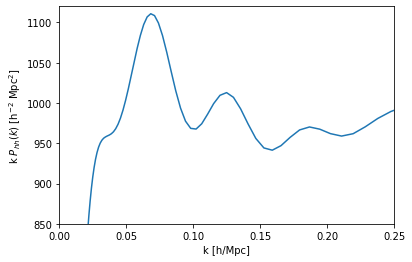

In [6]:
plt.plot(kv, kv * pk)

plt.xlim(0,0.25)
plt.ylim(850,1120)
plt.ylabel(r'k $P_{hh}(k)$ [h$^{-2}$ Mpc$^2$]')
plt.xlabel('k [h/Mpc]')
plt.show()

### Lagrangian Component Spectra ###
All spectra in LPT can be thought of as sums of cross spectra of bias operators $delta_X(q)$ shifted to their observed positions $x = q + \Psi$.

At up to third order these operators are $\{1, b_1, b_2, b_s, b_3\}$, not including derivative bias (which is roughly $b_1 \times k^2$) and stochastic contributions (e.g. shot noise).

In [7]:
# Let's explicitly list the components
# Note that the cross spectra are multiplied by a factor of one half.

kv = cleft.pktable[:,0]

spectra = {\
          r'$(1,1)$':cleft.pktable[:,1],\
          r'$(1,b_1)$':0.5*cleft.pktable[:,2], r'$(b_1,b_1)$': cleft.pktable[:,3],\
          r'$(1,b_2)$':0.5*cleft.pktable[:,4], r'$(b_1,b_2)$': 0.5*cleft.pktable[:,5],  r'$(b_2,b_2)$': cleft.pktable[:,6],\
          r'$(1,b_s)$':0.5*cleft.pktable[:,7], r'$(b_1,b_s)$': 0.5*cleft.pktable[:,8],  r'$(b_2,b_s)$':0.5*cleft.pktable[:,9], r'$(b_s,b_s)$':cleft.pktable[:,10],\
          r'$(1,b_3)$':0.5*cleft.pktable[:,11],r'$(b_1,b_3)$': 0.5*cleft.pktable[:,12]}

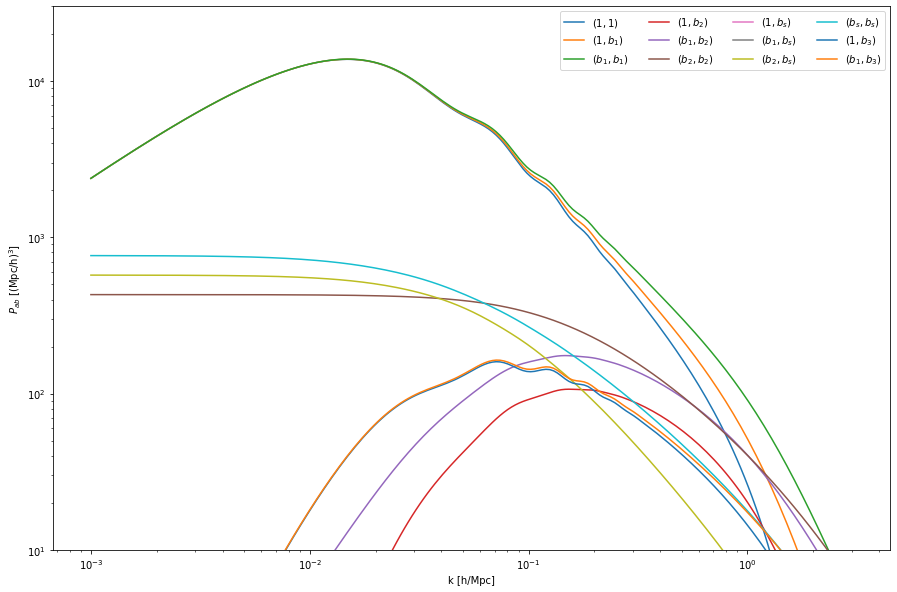

In [8]:
# Plot some of them!

plt.figure(figsize=(15,10))

spec_names = spectra.keys()

for spec_name in spec_names:    
    plt.loglog(kv, spectra[spec_name],label=spec_name)
plt.ylim(10,3e4)
plt.legend(ncol=4)
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$P_{ab}$ [(Mpc/h)$^3$]')  
plt.show()

### Bonus: Cross Spectra with Matter in Real Space ###
In the language of the component spectra the matter field is just "1."

This means we have straightforwardly

$P_{mm} = P_{11}$

and

$P_{hm} = P_{11} + b_1 P_{1b_1} + b_2 P_{1b_2} + b_s P_{1b_s} + b_3 P_{1b_3} + $ eft corrections.

In [9]:
# Note that if desired one can also add subleading k^n
# type stochastic corrections to these
def combine_bias_terms_pk_matter(alpha):
    kv  = cleft.pktable[:,0]
    ret = cleft.pktable[:,1] + alpha*kv**2 * cleft.pktable[:,13]
    return kv, ret

def combine_bias_terms_pk_crossmatter(b1,b2,bs,b3,alpha):
    kv  = cleft.pktable[:,0]
    ret = cleft.pktable[:,1] + 0.5*b1*cleft.pktable[:,2] \
        + 0.5*b2*cleft.pktable[:,4] + 0.5*bs*cleft.pktable[:,7] + 0.5*b3*cleft.pktable[:,11]\
        + alpha*kv**2 * cleft.pktable[:,13]
    return kv, ret

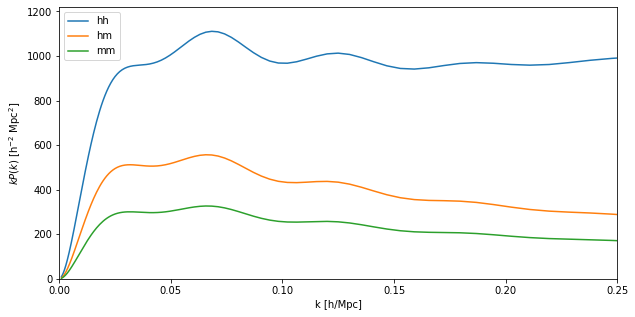

In [10]:
plt.figure(figsize=(10,5))

alpha_mm = 2
b1, b2, bs, b3, alpha_hm = 0.70, -1.3, -0.06, 0, 5

kv, phm = combine_bias_terms_pk_crossmatter(b1,b2,bs,b3,alpha_hm)
kv, pmm = combine_bias_terms_pk_matter(alpha_mm)

plt.plot(kv, kv * pk, label='hh')
plt.plot(kv, kv * phm, label='hm')
plt.plot(kv, kv * pmm, label='mm')

plt.xlim(0,0.25)
plt.ylim(0,1220)
plt.ylabel(r'$k P(k)$ [h$^{-2}$ Mpc$^2$]')
plt.xlabel('k [h/Mpc]')
plt.legend()
plt.show()